In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


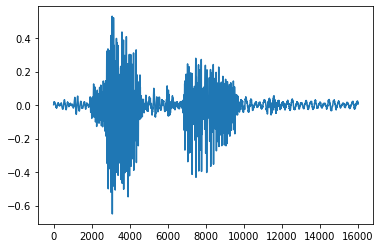

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=32, padding=1)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=40, stride=16, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fc2 = nn.Linear(64,1024)
        self.fc3 = nn.Linear(1024,16000)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.view(in_size, -1)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = x.unsqueeze(1)
        return 0.1 * F.tanh(x)

'''

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=2)
'''
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1, n_channel=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(7,7),stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d((2,4))
        self.conv2 = nn.Conv2d(n_channel, 2*n_channel, kernel_size=(5,5),stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(2*n_channel)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(2*n_channel, 4 * n_channel, kernel_size=(3,3),stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(4 * n_channel)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, n_output)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model2 = M6(n_input=1)
model.to(device)
model2.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=35, bias=True)
)
Number of parameters: 26323


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [16]:
transform_spec = torchaudio.transforms.Spectrogram()
transform = torchaudio.transforms.MFCC()

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [17]:
#oversampling
import random

attack_train = []
maintain_train = []
attack_num = 0
maintain_num = 0
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    transformed_spec = transform_spec(waveform)
    tran_sum = torch.sum(transformed_spec[0,:,:],dim=0)
   
    max_value = torch.max(tran_sum)
    
    for t in range(len(tran_sum)):
        if(tran_sum[t]> (max_value/10)):
            start=t*200
            break    
            
    
    if label == 'left':
        for k in range(5):
            attack_train.append((waveform, start, sample_rate, label, speaker_id, utterance_number))
        attack_num +=1
        
    else:
        rad = random.random()
        if (rad>0.7):
            attack_train.append((waveform,start, sample_rate, label, speaker_id, utterance_number))
            maintain_num+=1
print(attack_num,maintain_num)

        

3801 30657


In [18]:
attack_test_set = []

for i in range(len(test_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = test_set[i]
    transformed_spec = transform_spec(waveform)
    tran_sum = torch.sum(transformed_spec[0,:,:],dim=0)
   
    max_value = torch.max(tran_sum)
    
    for t in range(len(tran_sum)):
        if(tran_sum[t]> (max_value/10)):
            start=t*200
            break    
    print(start)
    
    attack_test_set.append((waveform, start, sample_rate, label, speaker_id, utterance_number))

print(len(attack_test_set))

4800
7000
9000
10200
5800
8600
6000
5000
3600
10400
9200
4400
6200
600
11800
2000
8000
5600
3000
9200
6000
6600
6600
7400
8200
7400
4800
6800
4200
6000
6200
6200
7400
0
9200
9000
9800
4600
3400
8000
7000
6400
2200
3200
4800
3000
11600
1800
7400
10800
4600
5600
4000
5600
2800
4400
4000
5000
3800
10600
8400
2600
8000
5400
1600
8200
10400
6600
2400
600
4600
10000
7000
400
800
5800
9200
4800
1000
7800
10800
800
2800
5000
4400
1200
5000
6200
3200
4800
1800
10600
1000
7200
7200
1600
4400
3000
2600
10000
5600
3400
5200
3200
5200
7000
6400
5400
0
7400
7400
2000
7000
2000
3800
3600
5200
7800
7000
4400
7800
6800
7800
1800
5800
8000
2800
6800
7000
5400
6600
0
7000
7200
6400
10600
5400
12000
1800
4400
3800
10600
4000
7200
2200
8200
3000
4400
4600
0
7000
5000
9600
5600
400
2200
7400
1000
8600
4800
4400
4600
5000
8800
11000
3600
3200
6200
0
6600
8200
11400
7800
1800
5800
3000
3000
5600
2000
3400
6600
6400
6000
4200
6400
4400
7800
2600
5800
5200
6800
6200
5600
7600
800
9000
8200
7200
8400
6800
12000


5000
600
4400
6800
3800
5600
6800
6800
7000
6400
11000
5800
0
10400
8600
10600
4200
9000
0
0
5800
5800
10000
12400
9000
7000
8800
8800
6800
3200
1000
8400
5200
0
0
8800
5000
6200
7600
9200
4000
200
1800
7400
6200
9000
4800
2000
2600
7000
8200
10200
5000
5400
8200
1600
2600
4800
9800
6800
3200
9000
5800
2800
1600
9000
13800
1400
10600
11000
4000
1800
2000
7800
4600
8400
1400
4600
3400
1000
4400
4800
4600
3600
2800
0
10800
9800
4200
200
2400
6200
8000
1400
9000
0
5600
0
7400
6600
8800
7600
400
8200
4800
3200
1600
7600
6800
12400
0
4800
6800
6200
9800
7200
5200
7600
0
6600
7800
8600
9800
4800
4200
4600
8600
7600
10000
0
5200
8600
5400
1600
8400
7600
8200
6800
10000
0
8800
7200
5400
1800
5200
3800
8000
3600
6000
9600
6400
8400
9400
6400
10200
7400
2000
9600
4200
9000
4000
8000
5400
4200
6400
6800
5800
2800
4800
11600
7400
8800
5200
0
3800
4000
5000
8400
2000
7800
3600
8400
5600
8200
7200
4000
8800
0
14200
9400
7200
5800
4000
5600
5800
5400
11600
3000
6800
8600
0
6400
7200
6800
7200
6600
92

8000
5600
6800
1600
6400
4600
5000
3400
5000
4800
8800
8800
6800
200
9600
800
200
0
2000
6600
5200
0
5200
5600
3400
6800
7200
8400
7000
3600
12000
3600
6800
3000
2600
5200
2200
3400
5600
6800
4000
10000
9000
9000
7000
8400
6800
2600
8000
11200
1800
4400
5400
5400
3000
4800
5800
8400
9200
6200
1400
3800
1800
6600
400
3400
2800
4200
1800
8200
4000
3000
4200
7000
8400
600
4800
8800
3600
5200
600
7000
3800
2200
0
4800
6800
1600
5000
1600
1200
9400
7200
2200
1800
400
0
3600
6800
5600
1800
2000
9200
6400
4800
9400
1400
6600
3800
14400
1000
1200
3000
3000
1800
3600
2000
6000
0
4600
6400
6000
2600
5800
3800
3600
7800
6800
4200
6600
4400
7600
8200
7600
1800
3800
1800
10200
1800
600
3000
4800
0
7400
5600
4600
1400
4000
7400
4200
4000
7000
4800
5600
3000
6000
6200
8800
6600
1800
5400
3600
3600
7800
4400
5000
2800
7000
2000
2000
8000
8600
3600
0
6800
1800
1600
1400
4600
9000
3200
1800
5800
1800
6600
2600
3200
5800
2400
7600
4400
200
3800
8800
6000
8400
3600
3800
6000
2400
2000
3600
3400
5200
6000


8800
4200
6400
6800
3400
5200
7400
8000
10600
0
3600
2000
9200
400
6200
4800
3000
7400
7800
1600
4400
8400
7800
4200
7800
7400
8600
8400
5800
8600
6000
3000
5800
10000
3800
4600
1600
4400
2200
9800
7800
5800
6600
6800
2000
4400
5200
2600
4800
8400
600
7200
1200
7600
10200
4800
1000
6600
2800
8800
8800
4600
9600
4400
9600
4600
4200
9600
3200
5400
12600
8800
4000
2000
3600
5400
2600
10400
4800
12600
3400
4000
2200
5600
8600
9800
8600
5000
4000
1000
6600
4600
400
7200
3200
800
4400
3000
2400
5400
7000
6800
9800
8400
6600
10600
10600
5000
9600
5000
9800
7400
9200
8400
6600
0
7000
5000
3800
9800
9600
5200
1200
2800
9800
15000
6400
5800
9400
10200
4600
4000
5600
9800
2600
2000
9400
400
4600
6800
3200
7600
7800
1200
7200
7200
3800
6400
8200
6400
11000
4600
200
4600
9200
7400
8400
7400
9400
3800
5400
7800
7800
6400
7400
11200
6600
2800
0
6600
8600
5400
5800
5400
6400
2600
10400
5000
8600
6400
10000
2400
8200
5000
6000
6000
6600
3400
6600
9000
5400
7000
8000
8400
12400
1000
7600
4400
4000
10600

5000
400
6000
3000
2600
6400
6400
13800
4600
4800
3400
1800
6400
8000
6800
5000
2000
8200
3200
11400
11400
2800
3800
9400
6200
8800
2000
5800
2000
4600
4800
4400
7600
9400
2200
6400
9000
7200
7000
8600
6600
7200
4800
2600
3400
2800
8400
7400
6600
8600
8200
9800
3200
2600
2400
1200
200
9800
3400
8600
7800
13200
6000
8000
6000
5000
2600
5400
3200
11600
3200
1800
5000
6000
7400
2400
8200
1800
3200
7600
6600
6000
2400
5800
8800
7000
3600
7400
9000
8200
8200
3400
6800
7400
1800
1200
4200
5800
3600
4000
6200
9600
2000
11800
6200
4400
7200
6000
6000
7800
4800
6600
8200
5600
9600
6000
6000
7800
4000
11600
0
4600
7400
2600
3400
8400
3800
1800
4000
6800
10800
5600
5400
13200
3600
2600
5800
3200
6000
8600
3600
5200
3000
7800
5800
6800
5600
4000
5000
7400
8200
6400
5400
5800
12200
6600
2000
5000
7800
3800
3800
5600
4600
5600
5400
2200
8000
1200
7400
8400
8200
7600
7800
8000
5400
8400
6600
12000
2000
7600
9200
5000
8800
4000
8000
4400
5800
2000
5000
2200
8600
1800
8600
4200
5000
2400
7000
5400
1400

9200
0
6600
5000
3600
3400
10800
8600
3400
12200
1400
7400
1800
10000
4800
0
2600
5400
8600
3400
5400
6600
5800
8200
6600
4800
6600
5000
9000
3600
4400
4200
4000
9200
7400
5200
10800
8800
12200
6800
6000
12400
6000
4400
200
12600
5600
8200
6400
3000
6600
2600
9800
7400
3000
3200
7600
7600
5200
6600
2400
5600
8200
4200
4800
7200
4200
4800
8400
8400
8800
4600
3200
4200
3400
5200
3000
10000
5600
5800
5600
2800
3600
10000
3000
5200
6600
7800
200
8000
6800
5600
1400
1400
6800
6000
2000
0
7000
3000
8800
1600
2800
2000
3600
3800
600
3800
7000
5600
8600
2000
3200
4000
2200
4000
7800
7800
7400
2000
6600
8800
2000
3400
4600
7200
5600
0
8200
6400
7800
4000
4600
6400
1800
7400
5800
1400
6600
1800
4600
5600
10800
4000
9000
6600
6800
1200
4200
8000
7400
5200
7000
7000
0
8800
7600
9600
200
1800
0
4200
4800
8200
5800
7000
8200
9400
6800
7000
5200
7200
1200
9400
3600
7400
6800
3800
3200
4000
6600
6800
4800
6200
9200
2200
6400
9000
8200
8200
6600
4200
7400
2800
5000
2800
6600
10400
5400
4000
2000
5000
3

11800
7000
5000
5800
4800
3000
6000
6400
2200
6600
8800
6600
11200
4200
3800
3600
2600
9400
9000
8800
12000
8800
8800
5800
7800
5200
11200
9200
1800
3200
600
7200
8600
8000
4600
2600
6400
5800
1800
2200
4600
7200
4600
8200
3000
3600
3400
8400
12000
6400
6200
2000
8600
10000
7000
8600
4200
9400
5200
4400
6600
8600
3400
10200
5600
9600
9600
3000
1400
2200
2600
4800
10000
600
8000
6600
2600
4000
7400
9800
2400
8200
7200
1200
4600
8200
11600
7200
0
4000
8000
2800
7600
3600
15600
2800
5800
4800
8800
9000
10600
2200
6600
3600
6600
3000
6600
2800
6600
2800
8600
6000
4000
8800
3000
2800
8000
4200
3600
1800
3200
4000
0
7400
11600
6600
6600
1200
5800
3000
2200
10600
6400
3400
6200
5800
7600
7400
3400
8200
10200
4800
5600
5200
3000
8400
5600
7000
1200
6200
4200
9200
0
6400
3600
7800
11400
4000
7200
3600
8200
6000
9000
2600
3000
0
7200
4800
4000
6400
3400
9200
7400
4800
1800
1800
3400
9800
4400
7800
3800
3600
1800
4600
7000
6200
2400
8800
8400
3000
3200
5400
5600
4000
3600
3800
7400
2000
6200
8600

In [19]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets, starts = [], [], []

    # Gather in lists, and encode labels as indices
    for waveform , start , _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]
        starts += [start]
    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)
 

    
    return tensors, targets, starts


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    attack_test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [20]:
class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        #print(sort_index,t)
        if sort_index[0].item()==t_index:
            if (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) 
            else:
                loss = torch.tensor(-0.3).to(device)
                #loss = -0.3
        else:
            loss = torch.exp(a[0]) - torch.exp(t[t_index]) 
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if a[0]==t[target.item()]:
            if (torch.exp(a[1]) - torch.exp(a[0])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(a[0]) 
            else:
                loss = torch.tensor(-0.2).to(device)
                #loss = -0.2
        else:
            loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            
        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, model2):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    model2.train()
    batch_sum = len(attack_train_loader)
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = p   
        
    for batch_idx, (data, target, starts) in enumerate(attack_train_loader):
        
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
        threshold = 0.1 + epoch // t_epoch * 0.07
        data = data.to(device)
        delta_ = model2(data)

        #delta_ = threshold*torch.tanh(0.25*delta)
        #delta_wav.append(delta_.abs().mean())
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data_ = delta_ + data
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data_2 = transform(data_)
        output = model(data_2)
        
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        
        loss_t = []
        loss_nt = []
        criterion = edge_loss()
        criterion2 = nt_loss()
        
        for i in range(len(target)):
            
            if target[i] == label_to_index('left').to(device):

                loss_t.append(criterion(output[i]))
            else:
                loss_nt.append(criterion2(output[i],target[i]))
        #print(len(loss_nt),len(loss_t),loss_t)
        loss_nt_mean = sum(loss_nt)/len(loss_nt)
        loss_t_mean = sum(loss_t)/len(loss_t)
        
        


        
        losses_t.append(loss_t_mean.item())
        losses_nt.append(loss_nt_mean.item())

        if epoch > 0:
            loss = 0.5 * loss_t_mean + 0.5 *loss_nt_mean 
            #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean 
        else:
            loss = 0.8 * loss_t_mean + 0.2 *loss_nt_mean 

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
        #grad = torch.autograd.grad(loss,delta)
        
        
        # print training stats
        if batch_idx % 200 == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [21]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, model2, wav_save = False):
    model.eval()
    model2.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target, starts in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = model2(data)
        #delta_ = threshold*torch.tanh(0.25*delta)
        
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        


    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [22]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [23]:
#method: DTA

import time


#model = torch.load('model.pkl')
model = torch.load('model_MFCC.pkl')

log_interval = 20
n_epoch = 400
threshold_epoch = 201
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam(model2.parameters(),lr = 0.0001, weight_decay=0.01)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):

        train_attack(model, epoch, log_interval, threshold_epoch, model2)
        
        kpi = test_attack(model, epoch,threshold_epoch, model2)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        #scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/49662 (0%)]	Loss: 0.417803

Test Epoch: 1	Attack_Accuracy: 356/412 (86%)


Test Epoch: 1	maintain_Accuracy: 7029/10593 (66%)

tensor(-0.1251, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 2 [0/49662 (0%)]	Loss: -0.125095

Test Epoch: 2	Attack_Accuracy: 377/412 (92%)


Test Epoch: 2	maintain_Accuracy: 7411/10593 (70%)

tensor(-0.1292, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 3 [0/49662 (0%)]	Loss: -0.129184

Test Epoch: 3	Attack_Accuracy: 389/412 (94%)


Test Epoch: 3	maintain_Accuracy: 7708/10593 (73%)

tensor(-0.1320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 4 [0/49662 (0%)]	Loss: -0.132030

Test Epoch: 4	Attack_Accuracy: 384/412 (93%)


Test Epoch: 4	mai


Train Epoch: 30	Attack_Accuracy: 18450/19005 (97%)


Train Epoch: 30	maintain_Accuracy: 27662/30657 (90%)

alpha: 0.49034992782993214

Test Epoch: 30	Attack_Accuracy: 401/412 (97%)


Test Epoch: 30	maintain_Accuracy: 9407/10593 (89%)

tensor(-0.2034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [0/49662 (0%)]	Loss: -0.203359

Test Epoch: 31	Attack_Accuracy: 402/412 (98%)


Test Epoch: 31	maintain_Accuracy: 9440/10593 (89%)

tensor(-0.2198, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 32 [0/49662 (0%)]	Loss: -0.219761

Test Epoch: 32	Attack_Accuracy: 404/412 (98%)


Test Epoch: 32	maintain_Accuracy: 9219/10593 (87%)

tensor(-0.2279, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [0/49662 (0%)]	Loss: -0.227909

Test Epoch: 33	Attack_Accuracy: 404/412 (98%)


Test Epoch: 33	maintain_Accura

tensor(-0.2048, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [0/49662 (0%)]	Loss: -0.204783

Test Epoch: 59	Attack_Accuracy: 401/412 (97%)


Test Epoch: 59	maintain_Accuracy: 9540/10593 (90%)

tensor(-0.2239, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 60 [0/49662 (0%)]	Loss: -0.223945

Train Epoch: 60	Attack_Accuracy: 18552/19005 (98%)


Train Epoch: 60	maintain_Accuracy: 28391/30657 (93%)

alpha: 0.5005417451684958

Test Epoch: 60	Attack_Accuracy: 403/412 (98%)


Test Epoch: 60	maintain_Accuracy: 9439/10593 (89%)

tensor(-0.2078, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 61 [0/49662 (0%)]	Loss: -0.207759

Test Epoch: 61	Attack_Accuracy: 397/412 (96%)


Test Epoch: 61	maintain_Accuracy: 9560/10593 (90%)

tensor(-0.2283, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='


Test Epoch: 87	Attack_Accuracy: 402/412 (98%)


Test Epoch: 87	maintain_Accuracy: 9557/10593 (90%)

tensor(-0.2299, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 88 [0/49662 (0%)]	Loss: -0.229929

Test Epoch: 88	Attack_Accuracy: 401/412 (97%)


Test Epoch: 88	maintain_Accuracy: 9592/10593 (91%)

tensor(-0.2152, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 89 [0/49662 (0%)]	Loss: -0.215248

Test Epoch: 89	Attack_Accuracy: 404/412 (98%)


Test Epoch: 89	maintain_Accuracy: 9545/10593 (90%)

tensor(-0.2326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 90 [0/49662 (0%)]	Loss: -0.232590

Train Epoch: 90	Attack_Accuracy: 18520/19005 (97%)


Train Epoch: 90	maintain_Accuracy: 28462/30657 (93%)

alpha: 0.5014826523579492

Test Epoch: 90	Attack_Accuracy: 404/412 (98%)


Test Epoch: 90	maintain_Accurac


Test Epoch: 115	Attack_Accuracy: 404/412 (98%)


Test Epoch: 115	maintain_Accuracy: 9520/10593 (90%)

tensor(-0.2219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 116 [0/49662 (0%)]	Loss: -0.221906

Test Epoch: 116	Attack_Accuracy: 404/412 (98%)


Test Epoch: 116	maintain_Accuracy: 9360/10593 (88%)

tensor(-0.2294, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [0/49662 (0%)]	Loss: -0.229431

Test Epoch: 117	Attack_Accuracy: 403/412 (98%)


Test Epoch: 117	maintain_Accuracy: 9570/10593 (90%)

tensor(-0.2227, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 118 [0/49662 (0%)]	Loss: -0.222719

Test Epoch: 118	Attack_Accuracy: 404/412 (98%)


Test Epoch: 118	maintain_Accuracy: 9384/10593 (89%)

tensor(-0.2211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<Mean


Test Epoch: 144	Attack_Accuracy: 402/412 (98%)


Test Epoch: 144	maintain_Accuracy: 9582/10593 (90%)

tensor(-0.2115, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 145 [0/49662 (0%)]	Loss: -0.211511

Train Epoch: 145	Attack_Accuracy: 18580/19005 (98%)


Train Epoch: 145	maintain_Accuracy: 28699/30657 (94%)

alpha: 0.5058819116627817

Test Epoch: 145	Attack_Accuracy: 402/412 (98%)


Test Epoch: 145	maintain_Accuracy: 9578/10593 (90%)

tensor(-0.2294, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 146 [0/49662 (0%)]	Loss: -0.229417

Test Epoch: 146	Attack_Accuracy: 403/412 (98%)


Test Epoch: 146	maintain_Accuracy: 9566/10593 (90%)

tensor(-0.2250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 147 [0/49662 (0%)]	Loss: -0.224987

Test Epoch: 147	Attack_Accuracy: 396/412 (96%)


Test Epoch: 147	mai


Test Epoch: 172	Attack_Accuracy: 388/412 (94%)


Test Epoch: 172	maintain_Accuracy: 9625/10593 (91%)

tensor(-0.2320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 173 [0/49662 (0%)]	Loss: -0.232046

Test Epoch: 173	Attack_Accuracy: 404/412 (98%)


Test Epoch: 173	maintain_Accuracy: 9315/10593 (88%)

tensor(-0.2289, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 174 [0/49662 (0%)]	Loss: -0.228928

Test Epoch: 174	Attack_Accuracy: 404/412 (98%)


Test Epoch: 174	maintain_Accuracy: 9265/10593 (87%)

tensor(-0.2197, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 175 [0/49662 (0%)]	Loss: -0.219669

Train Epoch: 175	Attack_Accuracy: 18580/19005 (98%)


Train Epoch: 175	maintain_Accuracy: 28759/30657 (94%)

alpha: 0.4990743047525976

Test Epoch: 175	Attack_Accuracy: 404/412 (98%)


Test Epoch: 175	mai


Test Epoch: 200	Attack_Accuracy: 404/412 (98%)


Test Epoch: 200	maintain_Accuracy: 9542/10593 (90%)

tensor(-0.2220, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 201 [0/49662 (0%)]	Loss: -0.222006

Test Epoch: 201	Attack_Accuracy: 398/412 (97%)


Test Epoch: 201	maintain_Accuracy: 9612/10593 (91%)

tensor(-0.2265, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 202 [0/49662 (0%)]	Loss: -0.226457

Test Epoch: 202	Attack_Accuracy: 387/412 (94%)


Test Epoch: 202	maintain_Accuracy: 9611/10593 (91%)

tensor(-0.2174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 203 [0/49662 (0%)]	Loss: -0.217434

Test Epoch: 203	Attack_Accuracy: 404/412 (98%)


Test Epoch: 203	maintain_Accuracy: 9579/10593 (90%)

tensor(-0.2287, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<Mean

tensor(-0.2262, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 229 [0/49662 (0%)]	Loss: -0.226203

Test Epoch: 229	Attack_Accuracy: 404/412 (98%)


Test Epoch: 229	maintain_Accuracy: 9537/10593 (90%)

tensor(-0.2355, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 230 [0/49662 (0%)]	Loss: -0.235500

Train Epoch: 230	Attack_Accuracy: 18593/19005 (98%)


Train Epoch: 230	maintain_Accuracy: 28756/30657 (94%)

alpha: 0.5018537971394911

Test Epoch: 230	Attack_Accuracy: 399/412 (97%)


Test Epoch: 230	maintain_Accuracy: 9628/10593 (91%)

tensor(-0.2343, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 231 [0/49662 (0%)]	Loss: -0.234349

Test Epoch: 231	Attack_Accuracy: 404/412 (98%)


Test Epoch: 231	maintain_Accuracy: 9596/10593 (91%)

tensor(-0.2219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.250

tensor(-0.2258, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [0/49662 (0%)]	Loss: -0.225753

Test Epoch: 257	Attack_Accuracy: 401/412 (97%)


Test Epoch: 257	maintain_Accuracy: 9627/10593 (91%)

tensor(-0.2209, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 258 [0/49662 (0%)]	Loss: -0.220941

Test Epoch: 258	Attack_Accuracy: 404/412 (98%)


Test Epoch: 258	maintain_Accuracy: 9479/10593 (89%)

tensor(-0.2174, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 259 [0/49662 (0%)]	Loss: -0.217387

Test Epoch: 259	Attack_Accuracy: 403/412 (98%)


Test Epoch: 259	maintain_Accuracy: 9568/10593 (90%)

tensor(-0.2242, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 260 [0/49662 (0%)]	Loss: -0.224207

Train Epoch: 260	Attack_Accuracy: 18622/19


Train Epoch: 285	Attack_Accuracy: 18609/19005 (98%)


Train Epoch: 285	maintain_Accuracy: 28774/30657 (94%)

alpha: 0.4996537815203618

Test Epoch: 285	Attack_Accuracy: 365/412 (89%)


Test Epoch: 285	maintain_Accuracy: 9646/10593 (91%)

tensor(-0.2060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 286 [0/49662 (0%)]	Loss: -0.205975

Test Epoch: 286	Attack_Accuracy: 405/412 (98%)


Test Epoch: 286	maintain_Accuracy: 9560/10593 (90%)

tensor(-0.2276, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 287 [0/49662 (0%)]	Loss: -0.227647

Test Epoch: 287	Attack_Accuracy: 405/412 (98%)


Test Epoch: 287	maintain_Accuracy: 9414/10593 (89%)

tensor(-0.2149, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 288 [0/49662 (0%)]	Loss: -0.214901

Test Epoch: 288	Attack_Accuracy: 405/412 (98%)


Test Epoch: 288	mai


Test Epoch: 313	Attack_Accuracy: 404/412 (98%)


Test Epoch: 313	maintain_Accuracy: 9596/10593 (91%)

tensor(-0.2287, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 314 [0/49662 (0%)]	Loss: -0.228747

Test Epoch: 314	Attack_Accuracy: 402/412 (98%)


Test Epoch: 314	maintain_Accuracy: 9607/10593 (91%)

tensor(-0.2309, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 315 [0/49662 (0%)]	Loss: -0.230854

Train Epoch: 315	Attack_Accuracy: 18622/19005 (98%)


Train Epoch: 315	maintain_Accuracy: 28867/30657 (94%)

alpha: 0.5011851175509234

Test Epoch: 315	Attack_Accuracy: 402/412 (98%)


Test Epoch: 315	maintain_Accuracy: 9583/10593 (90%)

tensor(-0.2270, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 316 [0/49662 (0%)]	Loss: -0.226981

Test Epoch: 316	Attack_Accuracy: 404/412 (98%)


Test Epoch: 316	mai


Test Epoch: 341	Attack_Accuracy: 390/412 (95%)


Test Epoch: 341	maintain_Accuracy: 9679/10593 (91%)

tensor(-0.2244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 342 [0/49662 (0%)]	Loss: -0.224403

Test Epoch: 342	Attack_Accuracy: 404/412 (98%)


Test Epoch: 342	maintain_Accuracy: 9583/10593 (90%)

tensor(-0.2206, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 343 [0/49662 (0%)]	Loss: -0.220606

Test Epoch: 343	Attack_Accuracy: 405/412 (98%)


Test Epoch: 343	maintain_Accuracy: 9539/10593 (90%)

tensor(-0.2217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 344 [0/49662 (0%)]	Loss: -0.221664

Test Epoch: 344	Attack_Accuracy: 402/412 (98%)


Test Epoch: 344	maintain_Accuracy: 9643/10593 (91%)

tensor(-0.2360, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<Mean

tensor(-0.2196, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 370 [0/49662 (0%)]	Loss: -0.219631

Train Epoch: 370	Attack_Accuracy: 18624/19005 (98%)


Train Epoch: 370	maintain_Accuracy: 28876/30657 (94%)

alpha: 0.5004013618000323

Test Epoch: 370	Attack_Accuracy: 402/412 (98%)


Test Epoch: 370	maintain_Accuracy: 9623/10593 (91%)

tensor(-0.2222, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 371 [0/49662 (0%)]	Loss: -0.222174

Test Epoch: 371	Attack_Accuracy: 405/412 (98%)


Test Epoch: 371	maintain_Accuracy: 9542/10593 (90%)

tensor(-0.2288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 372 [0/49662 (0%)]	Loss: -0.228843

Test Epoch: 372	Attack_Accuracy: 405/412 (98%)


Test Epoch: 372	maintain_Accuracy: 9601/10593 (91%)

tensor(-0.2396, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.250


Test Epoch: 398	Attack_Accuracy: 405/412 (98%)


Test Epoch: 398	maintain_Accuracy: 9561/10593 (90%)

tensor(-0.2132, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 399 [0/49662 (0%)]	Loss: -0.213219

Test Epoch: 399	Attack_Accuracy: 405/412 (98%)


Test Epoch: 399	maintain_Accuracy: 9542/10593 (90%)

tensor(-0.2356, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 400 [0/49662 (0%)]	Loss: -0.235602

Train Epoch: 400	Attack_Accuracy: 18625/19005 (98%)


Train Epoch: 400	maintain_Accuracy: 28827/30657 (94%)

alpha: 0.49932741799591646

Test Epoch: 400	Attack_Accuracy: 400/412 (97%)


Test Epoch: 400	maintain_Accuracy: 9601/10593 (91%)



tensor([[[ 0.2611,  0.4516, -0.2218,  ..., -0.2046, -0.3181, -0.2454]]],
       device='cuda:0', requires_grad=True)


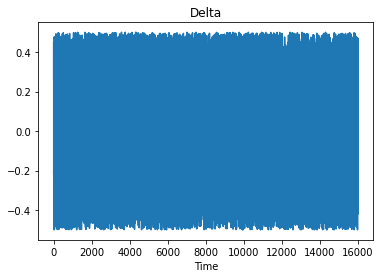

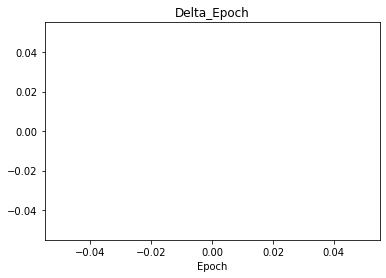

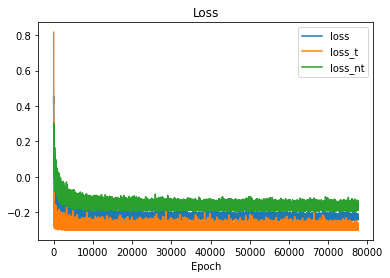

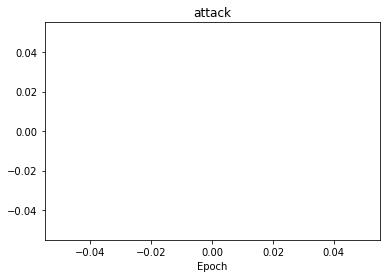

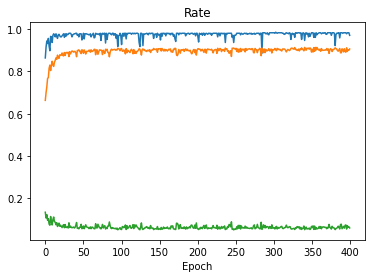

tensor([[ 0.0511,  0.0846, -0.0437,  ..., -0.0404, -0.0616, -0.0481]],
       grad_fn=<SqueezeBackward1>)


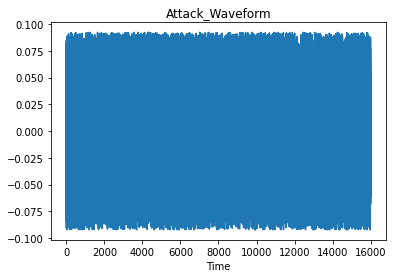

TypeError: test_attack() got an unexpected keyword argument 'delta'

In [24]:

time_ = time.strftime('%m_%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()


plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [ ]:
#test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch, model2)

In [ ]:
print(len(attack_train_loader))

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


